# Tuning MCTS params to support policy training

We are using the Upper Confidence Bound for MCTS

$$
U(s, a) = Q(s, a) + c_{puct} P(s, a) \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from tqdm import tqdm

from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame as Game
from aegomoku.interfaces import MctsParams
from aegomoku.constants_15x15 import *
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from aegomoku.utils import analyse_board

import tensorflow as tf

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
BOARD_SIZE = 15

In [4]:
project = tf.keras.layers.Conv2D(
    name='project',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    kernel_initializer=tf.constant_initializer([512, 256, 128, 64, 32, 16, 8, 4, 2, 1]))

peel = tf.keras.layers.Conv2D(
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([
        [[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]
    ]),
    bias_initializer=tf.constant_initializer(0.),
    trainable=False)

def print_channel(data, channel=None):
    """
    :param data: policy output, either one or six channels
    :param channel: if data is 6-channel, number of channel from 1: strongest offensive opportunity to 6 weakest defensive
    :return:
    """
    if np.shape(data)[-1] == 10:
        if channel is not None:
            channel -= 1
            data = np.expand_dims(data[:,:,:,channel], -1)
        else:
            data = project(data)
    data = peel(data)
    print((data.numpy().reshape([15, 15]) ).astype(np.uint))

---
### The initial setup

In [10]:
from aegomoku.policies.topological_value import TopologicalValuePolicy

stones = [C11, F9, E9, G8, F7, G7, G9, H8, G6]
from aegomoku.policies.heuristic_advice import HeuristicAdviserParams, HeuristicAdviser
policy_params = HeuristicAdviserParams(board_size=BOARD_SIZE, advice_threshold=.2)


def create_adviser(params):
    value_model = TopologicalValuePolicy(board_size=BOARD_SIZE, value_gauge=0.01)
    return HeuristicAdviser(params, value_model)

the_game = Game(BOARD_SIZE, initializer=ConstantBoardInitializer(stones))
mcts_params = MctsParams(cpuct=1.0, num_simulations=8000, temperature=0.0)

Considering 8000 positions:


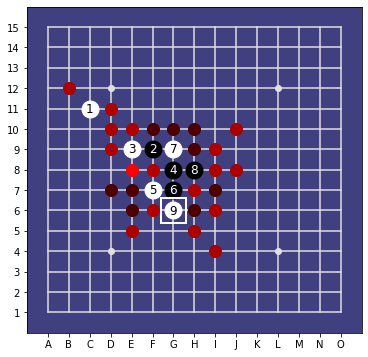

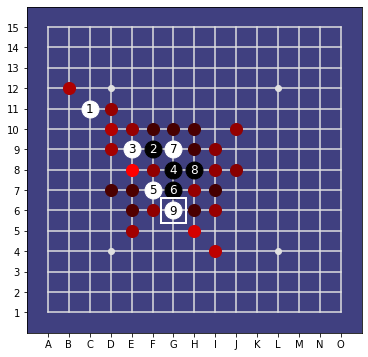

In [11]:
player = PolicyAdvisedGraphSearchPlayer(the_game, create_adviser, mcts_params, policy_params)
board = GomokuBoard(BOARD_SIZE, stones=stones)
adviser = create_adviser(policy_params)
analyse_board(BOARD_SIZE, stones, adviser, disp_width=6)
mcts = player.mcts
mcts_advice = player.mcts.get_action_prob(board, temperature=1.0)
analyse_board(BOARD_SIZE, stones, mcts_advice, disp_width=6, policy_cutoff=.001)

In [13]:
def best_move(mcts, board):
    probs = mcts.compute_probs(board, 0)
    best_move = int(np.squeeze(np.where(np.array(probs) == 1)))
    best_move = board.Stone(best_move)
    return best_move

E5
P-Value: -0.7847930788993835


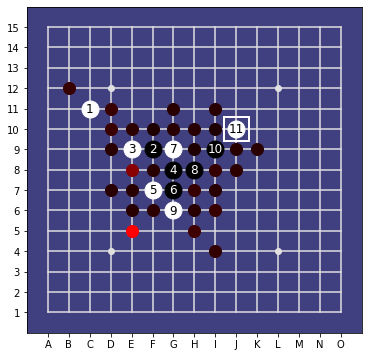

In [19]:
board = GomokuBoard(BOARD_SIZE, stones=stones)
move = best_move(mcts, board)
print(move)
print(f"P-Value: {adviser.evaluate(board.math_rep)[1]}")
mcts_advice = mcts.compute_probs(board, 3.0)
analyse_board(BOARD_SIZE, board.get_stones(), mcts_advice, disp_width=6, policy_cutoff=.001)

I6
P-Value: -0.7130681872367859


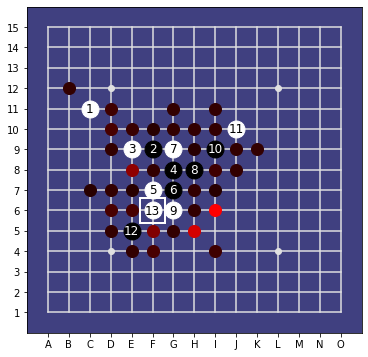

In [21]:
board.act(move.i)
move = best_move(mcts, board)
print(move)
print(f"P-Value: {adviser.evaluate(board.math_rep)[1]}")
mcts_advice = mcts.compute_probs(board, 3.0)
analyse_board(BOARD_SIZE, board.get_stones(), mcts_advice, disp_width=6, policy_cutoff=.001)

In [92]:
type(board.get_stones()[-1].c), type(stones[-1].c)

(int, int)

In [48]:
p, v = adviser.evaluate(board.math_rep)
v

0.24738832

In [32]:
mcts.best_act(board, s, actions)

I6

In [65]:
stones

[C11, F9, E9, G8, F7, G7, G9, H8, G6, I9, J10]

In [66]:
board.get_stones()

[C11, F9, E9, G8, F7, G7, G9, H8, G6, I9, J10, E5]

In [102]:
board.Stone(127).y

KeyboardInterrupt: 

# Essential Parameter: MCTS score read-out temperature
A readout temperature between 4 and 6 will produce a reasonable input for future advice!

Policy with decreasing readout temperatur


100%|██████████| 6/6 [00:00<00:00, 28.25it/s]


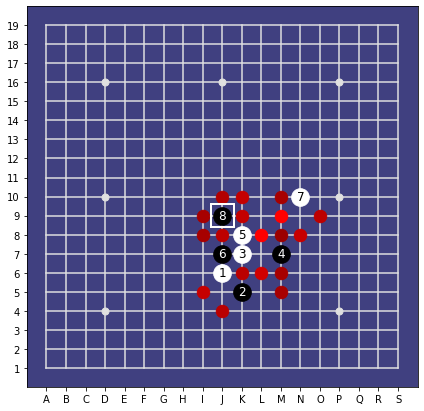

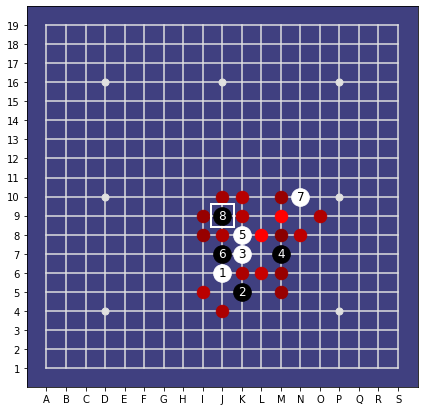

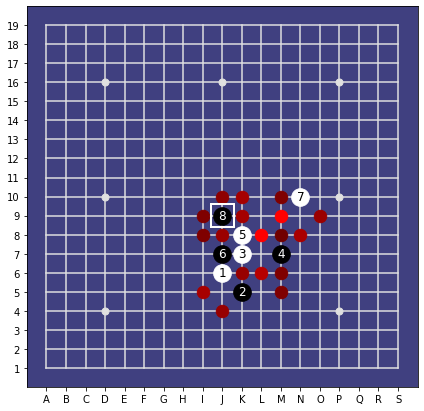

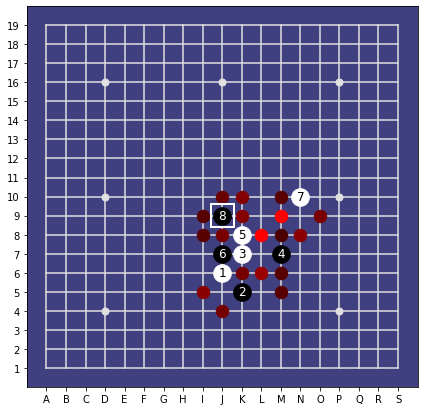

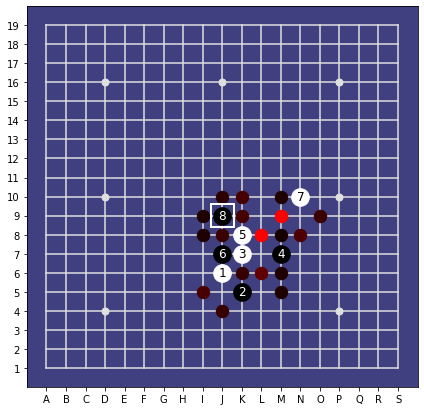

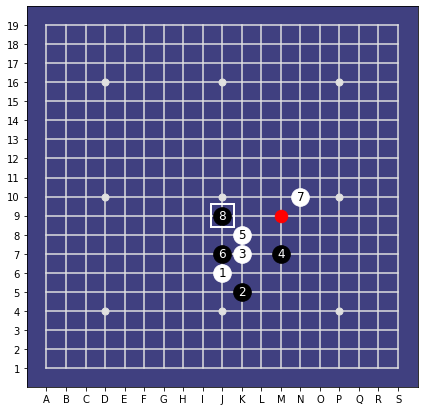

In [20]:
print("Policy with decreasing readout temperatur")
player.refresh()
player.mcts.get_action_prob(board)
for t in tqdm(range(10, -1, -2)):
    probs, v = player.evaluate(board, t)
    analyse_board(BOARD_SIZE, stones, probs, disp_width=7, policy_cutoff=.01)

In [26]:
probs, _ = player.evaluate(board, temperature=3)
print((np.reshape(probs, (BOARD_SIZE, BOARD_SIZE)) * 99 / np.max(probs)).astype(int))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16 25  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  0 25  0 99  0 21  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11 21  0 98  8 28  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 19 35 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 26  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0

In [14]:
(10**10 + 10**10)**.1

10.717734625362933